# Prediction of supporting Biden or Trump in the 2020 American election
Our goal is to understand which words are the most important for both voting groups. We will train a Naive Bayes classifier to classify the two groups and then evaluate the performance of the classifier on a validation set.
Then, we will understand which words have the highest (or lowest) posteriors, in order to understand which topics are the most relevant between the two voting basins.

In [1]:
import nltk
import pandas as pd
import numpy as np
import preprocessor as pre
import matplotlib.pyplot as plt
import random
random.seed(10) #it will be useful to have the same dictionary every time, in order to write it only once
import re                                  
import string                              
nltk.download('stopwords')
from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer        
from nltk.tokenize import TweetTokenizer 
import pickle
from os import getcwd
import json
import elections_utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/federico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
trump_df = pd.read_csv(r"./hashtag_donaldtrump.csv", lineterminator='\n')

In [3]:
biden_df = pd.read_csv(r"./hashtag_joebiden.csv", lineterminator='\n')

### Preprocessing of data

In [4]:
print(trump_df.shape)
print(biden_df.shape)
#the two datasets are not perfectly balanced, but probably sufficiently enough for NB to work

(970919, 21)
(776886, 21)


In [5]:
print(trump_df.info())
print(biden_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970919 entries, 0 to 970918
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            970919 non-null  object 
 1   tweet_id              970919 non-null  float64
 2   tweet                 970919 non-null  object 
 3   likes                 970919 non-null  float64
 4   retweet_count         970919 non-null  float64
 5   source                970043 non-null  object 
 6   user_id               970919 non-null  float64
 7   user_name             970903 non-null  object 
 8   user_screen_name      970919 non-null  object 
 9   user_description      869653 non-null  object 
 10  user_join_date        970919 non-null  object 
 11  user_followers_count  970919 non-null  float64
 12  user_location         675966 non-null  object 
 13  lat                   445719 non-null  float64
 14  long                  445719 non-null  float64
 15  

For this small project, we will only be interested in the tweets themselves, although many other interesting pieces of information may be retrieved from the dataset, such as the approval rate of the candidates inside vs outside the US or the amount of tweets from specific states

In [6]:
#we add a column for each candidate
#this is necessary to do supervised learning, since we will later remove the names of the candidates from the tweets
trump_df["Candidate"] = 'trump'
biden_df["Candidate"] = 'biden'

In [7]:
#mix the data together
Data_Mixed = pd.concat([trump_df,biden_df])
Data_Mixed.sort_values(by='created_at')
Data_Mixed.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,Candidate
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,trump
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,trump
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,trump
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,trump
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,trump


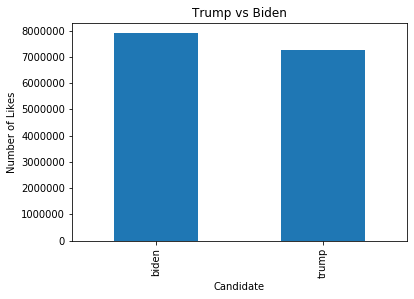

In [8]:
#note that the number of likes for pro-biden tweets is higher than the ones from trump supporters, although
#the total number of tweets pro-trump is higher
Data_Mixed.groupby('Candidate')['likes'].sum().plot.bar()
plt.ylabel('Number of Likes')
plt.title('Trump vs Biden')
plt.show()

In [9]:
#average number of likes for a pro-biden tweet vs a pro-trump tweet

print(f'Average number of likes of pro-trump tweets:'+ 
      str((Data_Mixed.loc[Data_Mixed['Candidate']=='trump']['likes'].sum())/float(trump_df.shape[0])))
print(f'Average number of likes of pro-biden tweets:'+ 
      str((Data_Mixed.loc[Data_Mixed['Candidate']=='biden']['likes'].sum())/float(biden_df.shape[0])))

Average number of likes of pro-trump tweets:7.4770109555997974
Average number of likes of pro-biden tweets:10.161163928813236


In [10]:
trump_tweets=trump_df.loc[trump_df['country']=='United States of America']['tweet'].tolist()
#notice that this will be considered a pro-trump tweet, since it has the #Trump.. that's normal data noise
print(trump_tweets[0])
print(len(trump_tweets))
#in case our classifier gets a high misclassification rate, then we might infer that tweets that talk about trump
#or biden use more or less the same words
#in that case, we may try to do a sentiment analysis for the two datasets separately

#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️
⠀
🌐https://t.co/qhIWpIUXsT
_
#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi
178899


In [11]:
biden_tweets=biden_df.loc[biden_df['country']=='United States of America']['tweet'].tolist()
print(biden_tweets[0])
print(len(biden_tweets))

#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️
⠀
🌐https://t.co/qhIWpIUXsT
_
#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi
153596


Notice that the above tweets are the same, for both candidates! We will remove them, in order to hopefully remove some noise

In [12]:
file=False
try:
    with open('./trump_tweets') as f:
        file=True
except IOError:
    print("File not accessible")

if file==False:
    random.shuffle(biden_tweets)
    random.shuffle(trump_tweets)
    print(len(trump_tweets))
    i=0
    for tweet in trump_tweets:
        i=i+1
        if('joe' or 'Joe' or 'JOE' or 'biden' or 'Biden' or 'BIDEN') in tweet:
            trump_tweets.remove(tweet)
    print(len(trump_tweets))
    print('end trump')
    i=0
    print(len(biden_tweets))
    for tweet in biden_tweets:
        i=i+1
        if('donald' or 'Donald' or 'DONALD' or 'trump' or 'Trump' or 'TRUMP') in tweet:
            biden_tweets.remove(tweet)
    print(len(biden_tweets))
    with open("trump_tweets", "wb") as fp:   #Pickling
        pickle.dump(trump_tweets, fp)
    with open("biden_tweets", "wb") as fp:   #Pickling
        pickle.dump(biden_tweets, fp)

        
if file==True:
    with open("trump_tweets", "rb") as fp:   # Unpickling
        trump_tweets = pickle.load(fp)
    with open("biden_tweets", "rb") as fp:   # Unpickling
        biden_tweets = pickle.load(fp)

In [13]:
#we use 10% of the tweets as test set
trump_train=trump_tweets[:-round(len(trump_tweets)/10)]
trump_test=trump_tweets[-round(len(trump_tweets)/10):]
biden_train=biden_tweets[:-round(len(biden_tweets)/10)]
biden_test=biden_tweets[-round(len(biden_tweets)/10):]
print(len(trump_train))
print(len(trump_test))
print(len(biden_train))
print(len(biden_test))

146132
16237
124530
13837


We now define a custom function for tweet preprocessing; not only we need to remove the usual stuff (hyperlinks, hashtags, ecc) but also the names of the candidates

You can find process_tweet and other helpful functions in the elections_utils file

In [14]:
print(elections_utils.process_tweet('@realDonaldTrump is a former entrepreneur in housing market'))
print(elections_utils.process_tweet('Biden has been a politician since he was twenty'))

['former', 'entrepreneur', 'hous', 'market']
['politician', 'sinc', 'twenti']


### Part 1: Trump-Biden Classification with Naive Bayes

In [15]:
#from now on, we will use trump=1, biden=0
x_train=trump_train+biden_train
x_test=trump_test+biden_test
y_train=np.append(np.ones(len(trump_train)), np.zeros(len(biden_train)))
y_test=np.append(np.ones(len(trump_test)), np.zeros(len(biden_test)))  

In [16]:
#the next function takes a dictionary and two lists (x and y) in input and outputs the dictionary
#to the dictionary, new entries are added
#the final dictionary has entries (word, 0/1)-->frequencies
#for instance, if "home" occurs twice in Biden tweets, the dictionary will map (home,0) into 2
try:
    with open("./elections_dictionary", "rb") as fp:   # Unpickling
        freqs_dict = pickle.load(fp)
except IOError:
    freqs_dict = elections_utils.count_tweets({}, x_train, y_train)
    with open("elections_dictionary", "wb") as fp:   #Pickling
        pickle.dump(freqs_dict, fp)


Of course NB is not really "trained", but the next function is called train_naive_bayse for semplicity.
The function takes in input the dictionary with the frequencies and the two lists (of tweets and (0,1)).
It returns the log prior (which is a number, since it is common to all words) and the log likelihood, which is a dictionary that maps every word into the corresponding log lokelihood


In [17]:
#since evaluating the loglikelihood is quite long, and the seed of the shuffling process is fixed,
#it is possible to directly load the files

try:
    with open("./elections_loglikelihood", "rb") as fp:   # Unpickling
        loglikelihood = pickle.load(fp)
    with open("./elections_logprior", "rb") as fp:   # Unpickling
        logprior = pickle.load(fp)
except IOError:
    logprior, loglikelihood = elections_utils.train_naive_bayes(freqs_dict, x_train, y_train)
    with open("elections_logprior", "wb") as fp:   #Pickling
        pickle.dump(logprior, fp)
    with open("elections_loglikelihood", "wb") as fp:   #Pickling
        pickle.dump(loglikelihood, fp)
#correctly, the log prior is greater than zero
print(logprior)
print(len(loglikelihood))

0.1599636721034231
111211


You can play with the next cell and try to see if some words that you think characterize a candidate have the very high (or very low, if negative) loglikelihood

In [18]:
print(elections_utils.naive_bayes_predict('MAGA God golf',logprior,loglikelihood))
print(elections_utils.naive_bayes_predict('hunter heal Delaware',logprior, loglikelihood))

2.296585836331416
-5.234388760385825


In [19]:
print("Naive Bayes accuracy = %0.4f" %
      (elections_utils.test_naive_bayes(x_test, y_test, logprior, loglikelihood)))

Naive Bayes accuracy = 0.7113


In [20]:
from collections import Counter
print(Counter(loglikelihood).most_common()[:20])
print(Counter(loglikelihood).most_common()[-20:])


[('vetsforsci', 6.494774067358912), ('fucksshit', 6.447026304485696), ('⚜', 5.838958133164327), ('operationmaga', 5.805301110160851), ('fs', 5.804077868418107), ('negligenthomicid', 5.8028531285222105), ('makeamericaunitedagain', 5.398612760309942), ('murdererinchief', 5.39493403145248), ('politicalview', 4.990082985383875), ('but-add', 4.973369504410134), ('racehorsetheori', 4.671859430351061), ('agonist', 4.627867861069527), ('arizonacircl', 4.426314942347685), ('kanganaranaut', 4.416558767402321), ('kiddwaya', 4.416558767402321), ('azkar', 4.416558767402321), ('eath', 4.355934145585886), ('eugen', 4.3133745311670895), ('unscientif', 4.285824579398859), ('=D', 4.179843138542567)]
[('mikeespym', -4.413106665272917), ('wedidntstartthefir', -4.44252055047921), ('re-shar', -4.44252055047921), ('billyl', -4.4569092879313095), ('demcast', -4.46503941401456), ("crazyuncledonnie'", -4.4710939229232665), ('demcastpa', -4.4710939229232665), ('follo', -4.602863200554389), ('4follo', -4.60286320

Unfortunately the accuracy is not particularly high. In part 3 we will try to divide the datasets into two sub-datasets each, taking into account the sentiment of the tweet. The reason for this is that tweets about both politicians may talk about the same topics, but with opposite sentiments

### Part 2: Sentiment analysis of Trump-Biden datasets

In this second part, we will take a pre-trained Naive Bayes model for sentiment analysis and evaluate the "average positiveness" of the two datasets of tweets.

In [21]:
#names are swapped (train_x instead of x_train) in order to not override the previous variables
nltk.download('twitter_samples',download_dir="./")

all_positive_tweets = []
all_negative_tweets = []
for line in open('./corpora/twitter_samples/positive_tweets.json', 'r'):
    all_positive_tweets.append(json.loads(line)['text'])
for line in open('./corpora/twitter_samples/negative_tweets.json', 'r'):
    all_negative_tweets.append(json.loads(line)['text'])

# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[1000:]
train_pos = all_positive_tweets[:7000]
test_neg = all_negative_tweets[1000:]
train_neg = all_negative_tweets[:7000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

# avoid assumptions about the length of all_positive_tweets
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

try:
    with open("./sample_loglikelihood", "rb") as fp:   # Unpickling
        sample_loglikelihood = pickle.load(fp)
    with open("./sample_logprior", "rb") as fp:   # Unpickling
        sample_logprior = pickle.load(fp)
#    with open("./sample_freqs", "rb") as fp:
#        sample_freqs = pickle.load(fp)
except IOError:       
    #names are swapped (train_x instead of x_train) in order to not override the previous variables
    print('evaluating freqs')
    sample_freqs = elections_utils.count_tweets({}, train_x, train_y)
    print('evaluating prior and likelihood')
    sample_logprior, sample_loglikelihood = elections_utils.train_naive_bayes(sample_freqs, train_x, train_y)
    with open("sample_logprior", "wb") as fp:   #Pickling
        pickle.dump(sample_logprior, fp)
    with open("sample_loglikelihood", "wb") as fp:   #Pickling
        pickle.dump(sample_loglikelihood, fp)
print("Naive Bayes accuracy = %0.4f" %(elections_utils.test_naive_bayes(test_x, test_y, sample_logprior, sample_loglikelihood)))
#the accuracy is >99%

[nltk_data] Downloading package twitter_samples to ./...
[nltk_data]   Package twitter_samples is already up-to-date!


Naive Bayes accuracy = 0.9968


In [22]:
log_posterior_trump=elections_utils.average_log_posterior(trump_tweets,sample_logprior, sample_loglikelihood)
log_posterior_biden=elections_utils.average_log_posterior(biden_tweets,sample_logprior, sample_loglikelihood)
print("Average positiveness (aka log posterior) of tweets about Trump: %0.4f"
      %(log_posterior_trump))
print("Average positiveness (aka log posterior) of tweets about Biden: %0.4f"
      %(log_posterior_biden))
#notice that the average of the log posterior is much different from the average of the posterior, and in general
#there is no link between the two, except that since the logarithmic and exponential functions are both monothonous,
#a higher logposterior implies a higher posterior

Average positiveness (aka log posterior) of tweets about Trump: -0.3546
Average positiveness (aka log posterior) of tweets about Biden: -0.1246


Working with the logs of posteriors makes quantifying how much more positive Biden tweets are quite difficult. If that was the goal of the project, using non-logarithmic posteriors would have been better

### Part 3: Sentiment analysis to filter tweets, and then Trump-Biden classification

In [25]:
pos_trump_tweets, neg_trump_tweets=elections_utils.divide_pos_neg(trump_tweets, [],[],sample_logprior, sample_loglikelihood)

In [26]:
pos_biden_tweets, neg_biden_tweets=elections_utils.divide_pos_neg(biden_tweets, [],[],sample_logprior, sample_loglikelihood)

In [27]:
print(len(trump_tweets))
print(len(pos_trump_tweets))
print(len(neg_trump_tweets))
print(len(biden_tweets))
print(len(pos_biden_tweets))
print(len(neg_biden_tweets))
#should be not surprised that the sum of pos+neg does not give the total, because some tweets contain only words 
#that are not in the sample dataset

162369
67942
86941
138367
61565
69768


#### Part 3.A: Analysis of positive tweets

In [28]:
pos_trump_train=pos_trump_tweets[:-round(len(pos_trump_tweets)/10)]
pos_trump_test=pos_trump_tweets[-round(len(pos_trump_tweets)/10):]
pos_biden_train=pos_biden_tweets[:-round(len(pos_biden_tweets)/10)]
pos_biden_test=pos_biden_tweets[-round(len(pos_biden_tweets)/10):]

In [29]:
pos_x_train=pos_trump_train+pos_biden_train
pos_x_test=pos_trump_test+pos_biden_test
pos_y_train=np.append(np.ones(len(pos_trump_train)), np.zeros(len(pos_biden_train)))
pos_y_test=np.append(np.ones(len(pos_trump_test)), np.zeros(len(pos_biden_test)))  

In [30]:
try:
    with open("./elections_pos_dictionary", "rb") as fp:   # Unpickling
        pos_freqs_dict = pickle.load(fp)
except IOError:
    pos_freqs_dict = elections_utils.count_tweets({}, pos_x_train, pos_y_train)
    with open("elections_pos_dictionary", "wb") as fp:   #Pickling
        pickle.dump(pos_freqs_dict, fp)

In [31]:
try:
    with open("./elections_pos_loglikelihood", "rb") as fp:   # Unpickling
        pos_loglikelihood = pickle.load(fp)
    with open("./elections_pos_logprior", "rb") as fp:   # Unpickling
        pos_logprior = pickle.load(fp)
except IOError:
    pos_logprior, pos_loglikelihood = elections_utils.train_naive_bayes(pos_freqs_dict, pos_x_train, pos_y_train)
    with open("elections_pos_logprior", "wb") as fp:   #Pickling
        pickle.dump(pos_logprior, fp)
    with open("elections_pos_loglikelihood", "wb") as fp:   #Pickling
        pickle.dump(pos_loglikelihood, fp)


In [32]:
print("Naive Bayes accuracy = %0.4f" %
      (elections_utils.test_naive_bayes(pos_x_test, pos_y_test, pos_logprior, pos_loglikelihood)))

Naive Bayes accuracy = 0.7120


In [33]:
print(Counter(pos_loglikelihood).most_common()[:10])
print(Counter(pos_loglikelihood).most_common()[-10:])

[('agonist', 4.685828829476688), ('rememberinnovemb', 4.5625306131321945), ('funfact', 4.362864942880268), ('politicalview', 4.226962944641409), ('refusestolead', 4.226962944641409), ('professionaladvic', 4.226962944641409), ('democratichoax', 4.226962944641409), ('happytalk', 4.226962944641409), ('didnthavetobethisway', 4.226962944641409), ('eath', 4.134181211190443)]
[('follo', -4.459973021361923), ('4follo', -4.459973021361923), ('🛍', -4.631121277557752), ('middle-eastern', -4.696361799426153), ('stopselectiontheft', -4.767457721109883), ('demcast', -4.887417036188863), ('teamjustic', -5.579113890171161), ('wtp', -5.772501232242204), ('wtpblue', -6.4278620771360115), ('wtpsenat', -7.467633865781187)]


#### Part 3.B: Analysis of negative tweets

In [34]:
neg_trump_train=neg_trump_tweets[:-round(len(neg_trump_tweets)/10)]
neg_trump_test=neg_trump_tweets[-round(len(neg_trump_tweets)/10):]
neg_biden_train=neg_biden_tweets[:-round(len(neg_biden_tweets)/10)]
neg_biden_test=neg_biden_tweets[-round(len(neg_biden_tweets)/10):]

In [35]:
neg_x_train=neg_trump_train+neg_biden_train
neg_x_test=neg_trump_test+neg_biden_test
neg_y_train=np.append(np.ones(len(neg_trump_train)), np.zeros(len(neg_biden_train)))
neg_y_test=np.append(np.ones(len(neg_trump_test)), np.zeros(len(neg_biden_test))) 

In [36]:
try:
    with open("./elections_neg_dictionary", "rb") as fp:   # Unpickling
        neg_freqs_dict = pickle.load(fp)
except IOError:
    neg_freqs_dict = elections_utils.count_tweets({}, neg_x_train, neg_y_train)
    with open("elections_neg_dictionary", "wb") as fp:   #Pickling
        pickle.dump(neg_freqs_dict, fp)

In [37]:
try:
    with open("./elections_neg_loglikelihood", "rb") as fp:   # Unpickling
        neg_loglikelihood = pickle.load(fp)
    with open("./elections_neg_logprior", "rb") as fp:   # Unpickling
        neg_logprior = pickle.load(fp)
except IOError:
    neg_logprior, neg_loglikelihood = elections_utils.train_naive_bayes(neg_freqs_dict, neg_x_train, neg_y_train)
    with open("elections_neg_logprior", "wb") as fp:   #Pickling
        pickle.dump(neg_logprior, fp)
    with open("elections_neg_loglikelihood", "wb") as fp:   #Pickling
        pickle.dump(neg_loglikelihood, fp)

In [38]:
print("Naive Bayes accuracy = %0.4f" %
      (elections_utils.test_naive_bayes(neg_x_test, neg_y_test, neg_logprior, neg_loglikelihood)))

Naive Bayes accuracy = 0.7038


In [39]:
print(Counter(neg_loglikelihood).most_common()[:10])
print(Counter(neg_loglikelihood).most_common()[-10:])

[('vetsforsci', 6.430334047507442), ('fucksshit', 6.398625620622301), ('⚜', 5.784727811716496), ('negligenthomicid', 5.739680633825898), ('fs', 5.738434527745651), ('makeamericaunitedagain', 5.737186866947496), ('operationmaga', 5.737186866947496), ('murdererinchief', 5.729668034533469), ('✳', 5.216743774110557), ('prone', 4.959408858048068)]
[('🔁', -4.573015013097228), ('ditchmoscowmitch', -4.658172821437535), ('stopselectiontheft', -4.7441632692930575), ('crony-stack', -4.860697085549009), ('cumul', -5.075808465165955), ('believeinamerica', -5.07983261546568), ('workload', -5.182780584718122), ('issick', -5.298952016480165), ('wtpsenat', -5.459533586637713), ('wtpblue', -5.827680931738683)]


In the end, the accuracy didn't improve much